# Custome CapsNet tensorflow model

In [186]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import pandas
import json
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd


class CapsNet(tf.keras.Model):
    def __init__(self, epochs, epsilon, m_minus, m_plus, lambda_, alpha, no_of_conv_kernels, no_of_primary_capsules, primary_capsule_vector, no_of_secondary_capsules, secondary_capsule_vector, r, train_metrics):
        super(CapsNet, self).__init__()
        self.epochs = epochs
        self.epsilon = epsilon
        self.m_minus = m_minus
        self.m_plus = m_plus
        self.lambda_ = lambda_
        self.alpha = alpha
        self.no_of_conv_kernels = no_of_conv_kernels
        self.no_of_primary_capsules = no_of_primary_capsules
        self.primary_capsule_vector = primary_capsule_vector
        self.no_of_secondary_capsules = no_of_secondary_capsules
        self.secondary_capsule_vector = secondary_capsule_vector
        self.r = r
        self.train_metrics = train_metrics
        self.training_metrics = None

        with tf.name_scope("Variables") as scope:
            self.convolution = tf.keras.layers.Conv2D(self.no_of_conv_kernels, [9,9], strides=[1,1], name='ConvolutionLayer', activation='relu')
            self.primary_capsule = tf.keras.layers.Conv2D(self.no_of_primary_capsules * self.primary_capsule_vector, [9,9], strides=[2,2], name="PrimaryCapsule")
            self.w = tf.Variable(tf.random_normal_initializer()(shape=[1, 1152, self.no_of_secondary_capsules, self.secondary_capsule_vector, self.primary_capsule_vector]), dtype=tf.float32, name="PoseEstimation", trainable=True)
            self.dense_1 = tf.keras.layers.Dense(units = 512, activation='relu')
            self.dense_2 = tf.keras.layers.Dense(units = 1024, activation='relu')
            self.dense_3 = tf.keras.layers.Dense(units = 784, activation='sigmoid', dtype='float32')
        self.build(input_shape=())

    def get_config(self):
        return {
            "epochs": self.epochs,
            "epsilon": self.epsilon,
            "m_minus": self.m_minus,
            "m_plus": self.m_plus,
            "lambda_": self.lambda_,
            "alpha": self.alpha,
            "no_of_conv_kernels": self.no_of_conv_kernels,
            "no_of_primary_capsules": self.no_of_primary_capsules,
            "no_of_secondary_capsules": self.no_of_secondary_capsules,
            "primary_capsule_vector": self.primary_capsule_vector,
            "secondary_capsule_vector": self.secondary_capsule_vector,
            "r": self.r,
            "train_metrics": self.train_metrics
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def squash(self, s):
        with tf.name_scope("SquashFunction") as scope:
            s_norm = tf.norm(s, axis=-1, keepdims=True)
            return tf.square(s_norm)/(1 + tf.square(s_norm)) * s/(s_norm + self.epsilon)

    @tf.function
    def call(self, inputs):
        input_x, y = inputs
        # input_x.shape: (None, 28, 28, 1)
        # y.shape: (None, 10)

        x = self.convolution(input_x) # x.shape: (None, 20, 20, 256)
        x = self.primary_capsule(x) # x.shape: (None, 6, 6, 256)

        with tf.name_scope("CapsuleFormation") as scope:
            u = tf.reshape(x, (-1, self.no_of_primary_capsules * x.shape[1] * x.shape[2], 8)) # u.shape: (None, 1152, 8)
            u = tf.expand_dims(u, axis=-2) # u.shape: (None, 1152, 1, 8)
            u = tf.expand_dims(u, axis=-1) # u.shape: (None, 1152, 1, 8, 1)
            u_hat = tf.matmul(self.w, u) # u_hat.shape: (None, 1152, 10, 16, 1)
            u_hat = tf.squeeze(u_hat, [4]) # u_hat.shape: (None, 1152, 10, 16)


        with tf.name_scope("DynamicRouting") as scope:
            b = tf.zeros((input_x.shape[0] if input_x.shape[0] else 1, 1152, self.no_of_secondary_capsules, 1)) # b.shape: (None, 1152, 10, 1)
            for i in range(self.r): # self.r = 3
                c = tf.nn.softmax(b, axis=-2) # c.shape: (None, 1152, 10, 1)
                s = tf.reduce_sum(tf.multiply(c, u_hat), axis=1, keepdims=True) # s.shape: (None, 1, 10, 16)
                v = self.squash(s) # v.shape: (None, 1, 10, 16)
                agreement = tf.squeeze(tf.matmul(tf.expand_dims(u_hat, axis=-1), tf.expand_dims(v, axis=-1), transpose_a=True), [4]) # agreement.shape: (None, 1152, 10, 1)
                # Before matmul following intermediate shapes are present, they are not assigned to a variable but just for understanding the code.
                # u_hat.shape (Intermediate shape) : (None, 1152, 10, 16, 1)
                # v.shape (Intermediate shape): (None, 1, 10, 16, 1)
                # Since the first parameter of matmul is to be transposed its shape becomes:(None, 1152, 10, 1, 16)
                # Now matmul is performed in the last two dimensions, and others are broadcasted
                # Before squeezing we have an intermediate shape of (None, 1152, 10, 1, 1)
                b += agreement

        with tf.name_scope("Masking") as scope:
            y = tf.expand_dims(y, axis=-1) # y.shape: (None, 10, 1)
            y = tf.expand_dims(y, axis=1) # y.shape: (None, 1, 10, 1)
            mask = tf.cast(y, dtype=tf.float32) # mask.shape: (None, 1, 10, 1)
            v_masked = tf.multiply(mask, v) # v_masked.shape: (None, 1, 10, 16)

        with tf.name_scope("Reconstruction") as scope:
            v_ = tf.reshape(v_masked, [-1, self.no_of_secondary_capsules * self.secondary_capsule_vector]) # v_.shape: (None, 160)
            reconstructed_image = self.dense_1(v_) # reconstructed_image.shape: (None, 512)
            reconstructed_image = self.dense_2(reconstructed_image) # reconstructed_image.shape: (None, 1024)
            reconstructed_image = self.dense_3(reconstructed_image) # reconstructed_image.shape: (None, 784)
        
        return v, reconstructed_image

    @tf.function
    def predict_capsule_output(self, inputs):
        x = self.convolution(inputs) # x.shape: (None, 20, 20, 256)
        x = self.primary_capsule(x) # x.shape: (None, 6, 6, 256)
        
        with tf.name_scope("CapsuleFormation") as scope:
            u = tf.reshape(x, (-1, self.no_of_primary_capsules * x.shape[1] * x.shape[2], 8)) # u.shape: (None, 1152, 8)
            u = tf.expand_dims(u, axis=-2) # u.shape: (None, 1152, 1, 8)
            u = tf.expand_dims(u, axis=-1) # u.shape: (None, 1152, 1, 8, 1)
            u_hat = tf.matmul(self.w, u) # u_hat.shape: (None, 1152, 10, 16, 1)
            u_hat = tf.squeeze(u_hat, [4]) # u_hat.shape: (None, 1152, 10, 16)

        
        with tf.name_scope("DynamicRouting") as scope:
            b = tf.zeros((inputs.shape[0], 1152, self.no_of_secondary_capsules, 1)) # b.shape: (None, 1152, 10, 1)
            for i in range(self.r): # self.r = 3
                c = tf.nn.softmax(b, axis=-2) # c.shape: (None, 1152, 10, 1)
                s = tf.reduce_sum(tf.multiply(c, u_hat), axis=1, keepdims=True) # s.shape: (None, 1, 10, 16)
                v = self.squash(s) # v.shape: (None, 1, 10, 16)
                agreement = tf.squeeze(tf.matmul(tf.expand_dims(u_hat, axis=-1), tf.expand_dims(v, axis=-1), transpose_a=True), [4]) # agreement.shape: (None, 1152, 10, 1)
                # Before matmul following intermediate shapes are present, they are not assigned to a variable but just for understanding the code.
                # u_hat.shape (Intermediate shape) : (None, 1152, 10, 16, 1)
                # v.shape (Intermediate shape): (None, 1, 10, 16, 1)
                # Since the first parameter of matmul is to be transposed its shape becomes:(None, 1152, 10, 1, 16)
                # Now matmul is performed in the last two dimensions, and others are broadcasted
                # Before squeezing we have an intermediate shape of (None, 1152, 10, 1, 1)
                b += agreement
        return v

    @tf.function
    def regenerate_image(self, inputs):
        with tf.name_scope("Reconstruction") as scope:
            v_ = tf.reshape(inputs, [-1, self.no_of_secondary_capsules * self.secondary_capsule_vector]) # v_.shape: (None, 160)
            reconstructed_image = self.dense_1(v_) # reconstructed_image.shape: (None, 512)
            reconstructed_image = self.dense_2(reconstructed_image) # reconstructed_image.shape: (None, 1024)
            reconstructed_image = self.dense_3(reconstructed_image) # reconstructed_image.shape: (None, 784)
        return reconstructed_image

    def safe_norm(self, v, axis=-1):
        v_ = tf.reduce_sum(tf.square(v), axis = axis, keepdims=True)
        return tf.sqrt(v_ + self.epsilon)

    def loss_function(self, v, reconstructed_image, y, y_image):
        prediction = self.safe_norm(v)
        prediction = tf.reshape(prediction, [-1, self.no_of_secondary_capsules])
        left_margin = tf.square(tf.maximum(0.0, self.m_plus - prediction))
        right_margin = tf.square(tf.maximum(0.0, prediction - self.m_minus))
        l = tf.add(y * left_margin, self.lambda_ * (1.0 - y) * right_margin)
        margin_loss = tf.reduce_mean(tf.reduce_sum(l, axis=-1))
        y_image_flat = tf.reshape(y_image, [-1, 784])
        reconstruction_loss = tf.reduce_mean(tf.square(y_image_flat - reconstructed_image))
        loss = tf.add(margin_loss, self.alpha * reconstruction_loss)
        return loss

    def fit(self, X, y, optimizer, batch_size=64):
        metrics = dict((el,[]) for el in self.train_metrics)
        metrics['loss'] = []
        training = tf.data.Dataset.from_tensor_slices((X, y))
        training = training.shuffle(buffer_size=len(training), reshuffle_each_iteration=True)
        training = training.batch(batch_size=batch_size)
        for i in range(1, self.epochs+1, 1):
            loss = 0
            with tqdm(total=len(training)) as pbar:
                pbar.set_description_str(f"Epoch {i}/{self.epochs}")
                for X_batch, y_batch in training:
                    y_one_hot = tf.one_hot(y_batch, depth=10)
                    with tf.GradientTape() as tape:
                        v, reconstructed_image = self([X_batch, y_one_hot])
                        loss += self.loss_function(v, reconstructed_image, y_one_hot, X_batch)
                    grad = tape.gradient(loss, self.trainable_variables)
                    optimizer.apply_gradients(zip(grad, self.trainable_variables))
                    pbar.update(1)
                loss /= len(X)
                pbar.set_postfix_str("Evaluating")
                y_preds = self.predict(X)
                if 'accuracy' in self.train_metrics:
                    metrics['accuracy'].append(accuracy_score(y, y_preds))
                if 'f1' in self.train_metrics:
                    metrics['f1'].append(f1_score(y, y_preds, average='weighted'))
                if 'precision' in self.train_metrics:
                    metrics['precision'].append(precision_score(y, y_preds, average='weighted'))
                if 'recall' in self.train_metrics:
                    metrics['recall'].append(recall_score(y, y_preds, average='weighted'))
                metrics['loss'].append(loss.numpy())
                pbar.set_postfix_str(f"Loss : {loss.numpy():.4f}")
        self.training_metrics = metrics
        return metrics

    def predict_proba(self, X):
        # In case X is a single element, create a batch of size 1
        if X.ndim == 3:
            X = tf.expand_dims(X, axis=0)
        pred = self.safe_norm(self.predict_capsule_output(X))
        pred = tf.squeeze(pred, [1])
        return pred

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)[:,0]

    def save(self, name, evaluate=None, classes=[]):
        # Calling tensorflow save method to save the model
        super(CapsNet, self).save(name)
        self.saved = True
        if not self.training_metrics:
            raise ValueError('The model bust be trained before being saved')
        # Model config
        with open(f'{self.name}/assets/config.json', 'w') as fp:
            json.dump(self.get_config(), fp)
        # Training metrics
        plot = pd.DataFrame(self.training_metrics).plot(title=f"metrics {model.name}")
        plot.figure.savefig(f'{self.name}/assets/training_metrics.pdf')
        if evaluate:
            if len(classes) == 0:
                raise ValueError('For saving model with classification metrics, add the classes (def save(self, name, evaluate=None, classes=[]):)')
            self.evaluate(evaluate[0], evaluate[1], classes, save=True)

    def evaluate(self, X_test, y_test, classes, save=False):
        preds = self.predict(X_test)
        # Classification metrics
        report = classification_report(y_test, preds, output_dict=True)
        df = pandas.DataFrame(report).transpose()
        # Confusion matrix
        cm = confusion_matrix(y_test, preds)
        df_cm = pd.DataFrame(cm, index = np.arange(10), columns = np.arange(10))
        plt.figure(figsize = (10,7))
        cm_plot = sn.heatmap(df_cm, annot=True)
        if save:
            if not self.saved:
                raise ValueError("Model has not been saved yet, the folder used to save the model doesn't exist yet, create it or call super(CapsNet, self).save(model_name)")
            df.to_csv(f'{self.name}/assets/classification_metrics.csv')
            cm_plot.figure.savefig(f'{self.name}/assets/confusion_matrix.png')
        else:
            plt.show()

# Getting dataset and predicting

In [187]:
(X_train, y_train), (X_test , y_test)= tf.keras.datasets.mnist.load_data()

X_train = X_train / 255.0
X_train = tf.cast(X_train, dtype=tf.float32)
X_train = tf.expand_dims(X_train, axis=-1)

X_test = X_test / 255.0
X_test = tf.cast(X_test, dtype=tf.float32)
X_test = tf.expand_dims(X_test, axis=-1)

X_train = X_train[:10]
y_train = y_train[:10]

X_test = X_test[:512]
y_test = y_test[:512]

In [188]:
params = {
    "epochs": 1,
    "epsilon": 1e-7,
    "m_minus": 0.1,
    "m_plus": 0.9,
    "lambda_": 0.5,
    "alpha": 0.0005,
    "no_of_conv_kernels": 128,
    "no_of_primary_capsules": 32,
    "no_of_secondary_capsules": 10,
    "primary_capsule_vector": 8,
    "secondary_capsule_vector": 16,
    "r":3,
    "train_metrics": ['accuracy', 'precision', 'recall', 'f1']
}

model = CapsNet(**params)
model.compile()
model.summary()

Model: "caps_net_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ConvolutionLayer (Conv2D)   multiple                  0 (unused)
                                                                 
 PrimaryCapsule (Conv2D)     multiple                  0 (unused)
                                                                 
 dense_84 (Dense)            multiple                  0 (unused)
                                                                 
 dense_85 (Dense)            multiple                  0 (unused)
                                                                 
 dense_86 (Dense)            multiple                  0 (unused)
                                                                 
Total params: 1,474,560
Trainable params: 1,474,560
Non-trainable params: 0
_________________________________________________________________


In [189]:
model.fit(X_train, y_train, tf.keras.optimizers.Adam())

Epoch 1/1: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it, Loss : 0.0800]


{'accuracy': ListWrapper([1.0]),
 'precision': ListWrapper([1.0]),
 'recall': ListWrapper([1.0]),
 'f1': ListWrapper([1.0]),
 'loss': ListWrapper([0.079990566])}

In [190]:
preds = model.predict(X_test)
preds

array([5, 1, 1, 5, 4, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 5, 1, 1, 1, 1,
       1, 5, 1, 5, 5, 4, 5, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 5, 1, 1,
       1, 5, 1, 1, 1, 4, 5, 1, 1, 1, 1, 3, 4, 1, 1, 1, 5, 1, 1, 1, 1, 1,
       1, 4, 1, 5, 5, 0, 5, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 5, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 5, 4, 5, 1, 5, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 5, 1, 5, 1, 1, 1, 5, 1, 1, 1, 1, 1,
       5, 1, 1, 1, 5, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 5,
       1, 1, 1, 5, 1, 1, 1, 1, 5, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 3, 0, 1, 1, 1, 5, 1, 5, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 4, 1, 1, 1, 1, 5, 1, 1, 1, 1,
       5, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 3,
       1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 5, 5, 5, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 4, 1, 5, 1, 1, 1, 1, 5, 3, 0, 5, 1, 1, 1,

# Loading and Saving

INFO:tensorflow:Assets written to: caps_net_28/assets


INFO:tensorflow:Assets written to: caps_net_28/assets
/Users/mat/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mat/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mat/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

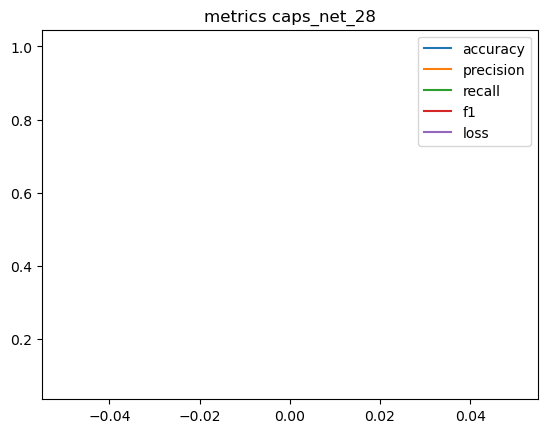

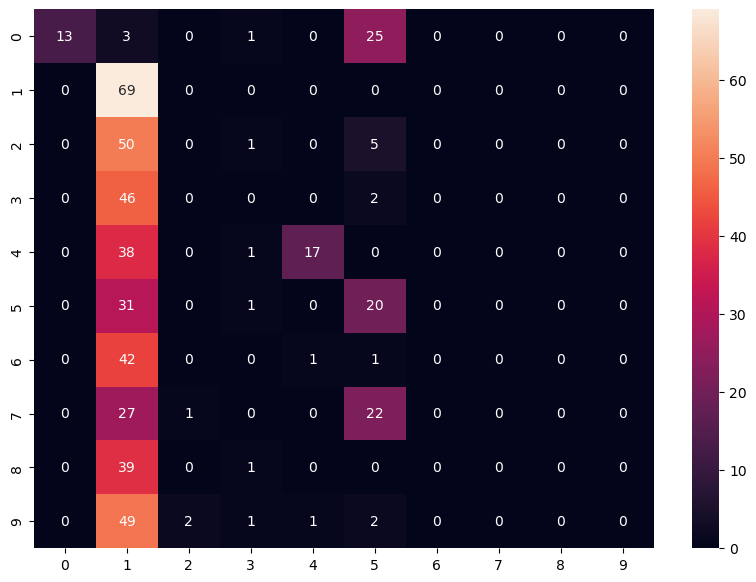

In [191]:
model.save(model.name, evaluate=(X_test, y_test), classes=np.arange(10))

In [192]:
loaded_model = tf.keras.models.load_model('caps_net_11', custom_objects={'CapsNet': CapsNet})
loaded_model.compile()
loaded_model.summary()

Model: "caps_net_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ConvolutionLayer (Conv2D)   multiple                  20992     
                                                                 
 PrimaryCapsule (Conv2D)     multiple                  5308672   
                                                                 
 dense_87 (Dense)            multiple                  82432     
                                                                 
 dense_88 (Dense)            multiple                  525312    
                                                                 
 dense_89 (Dense)            multiple                  803600    
                                                                 
Total params: 8,215,568
Trainable params: 8,215,568
Non-trainable params: 0
_________________________________________________________________


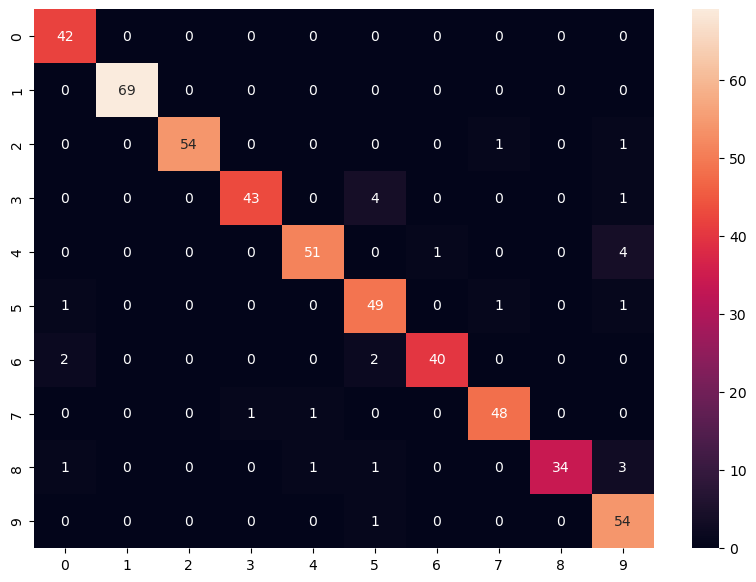

In [193]:
loaded_model.evaluate(X_test, y_test, np.arange(0,9))